In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import itertools
import swifter

c:\programdata\miniconda3\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
df_lyrics = pd.read_csv("data/lyrics.csv", sep =';')

df_lyrics[:5]

,ALink,SName,SLink,Lyric,ParentGenre,Genres,Genres_API
0,/andre-drake/,Bae ft. V.P Rap,/andre-drake/bae-ft-v-p-rap.html,[André Drake]. Minha princesa eu troco tudo pr...,Black Music,"Black Music, Hip Hop, Rap","Black Music, Hip Hop, Rap"
1,/andre-drake/,By Chance (Brazilian Remix),/andre-drake/by-chance-brazilian-remix.html,"[Refrão]. Mais views, pode ser?. Cê sabe, que ...",Black Music,"Black Music, Hip Hop, Rap","Black Music, Hip Hop, Rap"
2,/andre-drake/,Casa do Terror,/andre-drake/casa-do-terror.html,"4 Paredes uma jaula, na minha mão uma faca. Um...",Black Music,"Black Music, Hip Hop, Rap","Black Music, Hip Hop, Rap"
3,/andre-drake/,Na Madrugada,/andre-drake/na-madrugada.html,"[Refrão 1]. Na ""madruga"" não consigo dormir. m...",Black Music,"Black Music, Hip Hop, Rap","Black Music, Hip Hop, Rap"
4,/andre-drake/,V.P Convida Parte 2,/andre-drake/v-p-convida-parte-2.html,[Vp Rap]. Vp de novo que convida. Dessa vez se...,Black Music,"Black Music, Hip Hop, Rap","Black Music, Hip Hop, Rap"


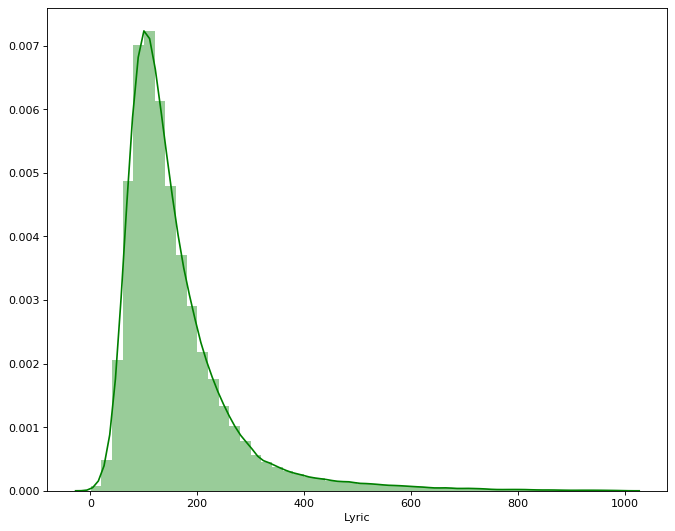

In [3]:
# Distribuição do número de palavras ao longo do dataset

len_serie = df_lyrics["Lyric"].str.split(' ').map(lambda x: len(x))
fig=plt.figure(figsize=(10, 8), dpi= 80)
sns.distplot(len_serie[len_serie<1000], color="g")

In [3]:
# Utilizar os gêneros trazidos pela API distorce muito o resultado, pois são demasiadamente numerosos.
# Utilizar apenas os 3 principais produziu uma visualização final melhor.

use_API = False
column_Genres = "Genres"
if(use_API):
    column_Genres = "Genres_API"

serie_genres_b = df_lyrics[column_Genres].value_counts()
df_genres = pd.DataFrame({"Genres":serie_genres_b.index, "Count": serie_genres_b}).reset_index(drop=True)

df_genres["Genres"] = df_genres["Genres"].str.split(', ')

# Dataframe construído para facilitar o cálculo das visões de correlação.
df_genres[0:5]

,Genres,Count
0,"[Sertanejo, Romântico, Country]",3822
1,[Gospel/Religioso],3564
2,"[Romântico, Sertanejo, Country]",1895
3,[Sertanejo],1723
4,"[Sertanejo, Romântico, Forró]",1708


In [4]:
genres = {}
for i in df_genres.index:
    genres_arr = df_genres["Genres"][i]
    for genre in genres_arr:
        genres[genre] = ''
genres = np.sort(list(genres.keys()))
# Todos os gêneros
genres

array(['Axé', 'Black Music', 'Blues', 'Bossa Nova', 'Chillout',
       'Classic Rock', 'Clássico', 'Country', 'Dance', 'Disco',
       'Electro Swing', 'Electronica', 'Emocore', 'Fado', 'Folk', 'Forró',
       'Funk', 'Funk Carioca', 'Gospel/Religioso', 'Grunge', 'Gótico',
       'Hard Rock', 'Hardcore', 'Heavy Metal', 'Hip Hop', 'House',
       'Indie', 'Industrial', 'Infantil', 'Instrumental', 'J-Pop/J-Rock',
       'Jazz', 'Jovem Guarda', 'K-Pop/K-Rock', 'Kizomba', 'MPB', 'Metal',
       'Músicas Gaúchas', 'New Age', 'New Wave', 'Pagode', 'Piano Rock',
       'Pop', 'Pop/Punk', 'Pop/Rock', 'Post-Rock', 'Power-Pop',
       'Progressivo', 'Psicodelia', 'Punk Rock', 'Pós-Punk', 'R&B', 'Rap',
       'Reggae', 'Reggaeton', 'Regional', 'Rock', 'Rock Alternativo',
       'Rockabilly', 'Romântico', 'Samba', 'Samba Enredo', 'Sertanejo',
       'Ska', 'Soft Rock', 'Soul Music', 'Surf Music', 'Tecnopop',
       'Trance', 'Trilha Sonora', 'Trip-Hop', 'Tropical House',
       'Velha Guarda', 'Wo

In [6]:
# Produzindo visão de mapa de correlação (deprecada)
# Cada quadrado do mapa representa a proporção entre o número de músicas que
# aparecem em um gênero ou em outro pelo número de músicas que ocorrem nos dois ao mesmo tempo.

df_or = pd.DataFrame(columns=genres, index =genres).fillna(0)
df_and = pd.DataFrame(columns=genres, index =genres).fillna(0)

def process(linha):
 
    genres_arr = linha['Genres']
    count      = linha['Count']
    
    global df_or
    global df_and
    
    df = pd.DataFrame(columns=genres, index =genres).fillna(0)
    for genre in genres_arr:
        
        df[genre] = count
        df.loc[genre:genre] = count
        df_and[genre][genre] += count
        
    df_or = df_or.add(df)
    for subset in itertools.combinations(genres_arr, 2):
        df_and[subset[0]][subset[1]] += count
        df_and[subset[1]][subset[0]] += count
    
       
start = time.time()    
df_genres.apply(lambda linha: process(linha), axis =1)
end = time.time()

df_corr = df_and/df_or

print('\nTime(s): '+str("%.2f" % (end - start)+'s\n'))


Time(s): 34.18s



In [7]:
df_corr = df_corr.round(3)
df_corr

,Axé,Black Music,Blues,Bossa Nova,Chillout,Classic Rock,Clássico,Country,Dance,Disco,...,Soft Rock,Soul Music,Surf Music,Tecnopop,Trance,Trilha Sonora,Trip-Hop,Tropical House,Velha Guarda,World Music
Axé,1.000,0.014,0.010,0.006,0.009,0.000,0.044,0.020,0.020,0.035,...,0.000,0.000,0.000,0.001,0.000,0.011,0.000,0.0,0.010,0.000
Black Music,0.014,1.000,0.020,0.000,0.000,0.000,0.000,0.016,0.001,0.000,...,0.000,0.075,0.000,0.000,0.000,0.002,0.002,0.0,0.000,0.003
Blues,0.010,0.020,1.000,0.018,0.000,0.008,0.016,0.004,0.001,0.000,...,0.000,0.005,0.000,0.000,0.000,0.030,0.000,0.0,0.024,0.000
Bossa Nova,0.006,0.000,0.018,1.000,0.013,0.000,0.018,0.000,0.000,0.000,...,0.000,0.011,0.000,0.000,0.000,0.005,0.000,0.0,0.054,0.011
Chillout,0.009,0.000,0.000,0.013,1.000,0.000,0.000,0.000,0.002,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.013,0.0,0.000,0.000
Classic Rock,0.000,0.000,0.008,0.000,0.000,1.000,0.000,0.001,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000
Clássico,0.044,0.000,0.016,0.018,0.000,0.000,1.000,0.001,0.006,0.011,...,0.000,0.006,0.000,0.000,0.000,0.037,0.000,0.0,0.026,0.013
Country,0.020,0.016,0.004,0.000,0.000,0.001,0.001,1.000,0.001,0.000,...,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.0,0.001,0.000
Dance,0.020,0.001,0.001,0.000,0.002,0.000,0.006,0.001,1.000,0.000,...,0.000,0.000,0.000,0.012,0.000,0.025,0.000,0.0,0.000,0.000
Disco,0.035,0.000,0.000,0.000,0.000,0.000,0.011,0.000,0.000,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.020,0.000


In [11]:
columns = []
for i in df_corr.columns:
    for j in df_corr.columns:
        if(i!=j):
            if(df_corr[i][j]>0.2 and i not in columns):
                columns.append(i)
columns

['Country',
 'Fado',
 'Funk',
 'Funk Carioca',
 'Hardcore',
 'Hip Hop',
 'Pagode',
 'Pop/Rock',
 'Punk Rock',
 'Rap',
 'Rock',
 'Romântico',
 'Samba',
 'Sertanejo',
 'World Music']

In [12]:
df = df_corr[columns].loc[columns]

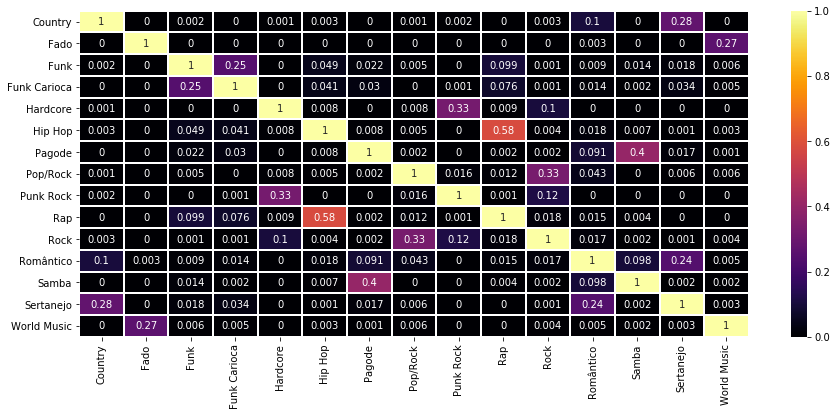

In [13]:
# Visão deprecada! A última visão (relacionamento gênero pai e filho) traz a informação útil de fato
fig, ax = plt.subplots(figsize=(15,6))   
sns.heatmap(df.round(4), cmap = 'inferno', annot=True, linewidth = 1)
plt.show()

In [14]:
df_lyrics["SizeGenres"] = df_lyrics["Genres"].str.split(',').map(lambda x: len(x))
df_lyrics["SizeGenres"].value_counts()

3    137134
1     10417
2     10361
Name: SizeGenres, dtype: int64

In [15]:
# Distribuição das músicas cujos artistas possuem apenas 1 gênero listado
df_2 = df_lyrics[df_lyrics["SizeGenres"]==1]
df_2["ParentGenre"].value_counts()

Gospel/Religioso    3564
Sertanejo           1723
Romântico            940
MPB                  514
Funk Carioca         404
Rap                  394
Forró                384
Pop/Rock             337
Rock                 285
Pop                  258
Reggae               208
Samba                203
World Music          142
Rock Alternativo     113
Pagode               112
Samba Enredo         109
Bossa Nova           101
Infantil              81
Hip Hop               75
Punk Rock             71
Heavy Metal           63
Folk                  56
Hardcore              39
Trilha Sonora         38
Indie                 31
Fado                  23
Regional              22
Hard Rock             18
Kizomba               15
Blues                 15
Dance                 11
Country               10
Electronica           10
Metal                  9
Black Music            9
Funk                   6
R&B                    5
New Age                5
Jovem Guarda           3
J-Pop/J-Rock           3


In [16]:
# Distribuição de gênero principal entre todas as músicas listadas
serie_parent_genre = df_lyrics["ParentGenre"].value_counts()

# Gêneros selecionados com critério simples: todos que possuem mais de 2500 instâncias
generos_selecionados = list(serie_parent_genre[serie_parent_genre >2500].index)
serie_parent_genre

Gospel/Religioso    33586
Sertanejo           23947
MPB                 13586
Romântico           13352
Forró               10734
Samba                7420
Pop/Rock             5431
Rock                 4485
Funk Carioca         4209
Pagode               4174
Rap                  3920
Pop                  3535
Infantil             2960
Velha Guarda         2782
Regional             2680
Hip Hop              2269
Reggae               2151
Bossa Nova           2115
Trilha Sonora        1683
Axé                  1217
Samba Enredo         1205
Rock Alternativo     1115
Punk Rock             946
Jovem Guarda          939
Hardcore              735
Fado                  680
Indie                 655
Soul Music            630
World Music           434
Dance                 403
                    ...  
Emocore               130
Metal                 128
Pós-Punk              119
Blues                 113
Funk                  101
Psicodelia             94
Gótico                 80
Clássico    

In [17]:
df_total = pd.DataFrame(columns=genres, index =genres).fillna(0)
df_and = pd.DataFrame(columns=genres, index =genres).fillna(0)

# Produzindo visão de mapa de correlação (nova!)
# Cada quadrado do mapa representa a proporção de músicas de um gênero pai nas quais também aparece o gênero filho.
# Esta visão não produz uma matriz simétrica. E também produz um mapa de calor muito maior que o anterior.
# Tornando a visualização inviável. Logo, foi escolhido exibir o resultado em uma tabela (última célula).

def process(linha):
 
    genres_arr = linha['Genres']
    count      = linha['Count']
    
    global df_total
    global df_and
    
    for genre in genres_arr:
        
        df_total[genre] += count
        df_and[genre][genre] += count
        
    for subset in itertools.combinations(genres_arr, 2):
        df_and[subset[0]][subset[1]] += count
        df_and[subset[1]][subset[0]] += count
    
start = time.time()    
df_genres.apply(lambda linha: process(linha), axis =1)
end = time.time()

df_corr = df_and/df_total

print('\nTime(s): '+str("%.2f" % (end - start)+'s\n'))


Time(s): 3.11s



In [18]:
df_corr = df_corr.round(3)
df_corr

,Axé,Black Music,Blues,Bossa Nova,Chillout,Classic Rock,Clássico,Country,Dance,Disco,...,Soft Rock,Soul Music,Surf Music,Tecnopop,Trance,Trilha Sonora,Trip-Hop,Tropical House,Velha Guarda,World Music
Axé,1.000,0.068,0.107,0.022,0.464,0.000,0.119,0.055,0.117,0.339,...,0.00,0.005,0.001,0.113,0.00,0.034,0.000,0.0,0.041,0.000
Black Music,0.017,1.000,0.066,0.000,0.000,0.000,0.000,0.023,0.002,0.000,...,0.00,0.245,0.000,0.000,0.00,0.003,0.133,0.0,0.000,0.009
Blues,0.011,0.028,1.000,0.023,0.000,0.078,0.019,0.005,0.001,0.000,...,0.02,0.011,0.000,0.000,0.00,0.035,0.000,0.0,0.031,0.001
Bossa Nova,0.008,0.000,0.083,1.000,0.272,0.000,0.031,0.000,0.000,0.000,...,0.00,0.051,0.000,0.000,0.00,0.010,0.000,0.0,0.112,0.049
Chillout,0.009,0.000,0.000,0.014,1.000,0.000,0.000,0.000,0.002,0.000,...,0.00,0.000,0.000,0.000,0.00,0.000,0.067,0.0,0.000,0.000
Classic Rock,0.000,0.000,0.008,0.000,0.000,1.000,0.000,0.001,0.000,0.000,...,0.00,0.000,0.000,0.000,0.00,0.000,0.000,0.0,0.000,0.000
Clássico,0.064,0.000,0.100,0.044,0.000,0.000,1.000,0.003,0.021,0.061,...,0.00,0.040,0.000,0.000,0.00,0.079,0.000,0.0,0.067,0.083
Country,0.031,0.051,0.028,0.000,0.000,0.065,0.003,1.000,0.003,0.000,...,0.00,0.000,0.000,0.000,0.00,0.004,0.000,0.0,0.003,0.001
Dance,0.023,0.002,0.003,0.000,0.023,0.000,0.008,0.001,1.000,0.000,...,0.00,0.000,0.000,0.225,0.00,0.036,0.000,0.0,0.000,0.000
Disco,0.038,0.000,0.000,0.000,0.000,0.000,0.013,0.000,0.000,1.000,...,0.00,0.000,0.000,0.000,0.00,0.000,0.000,0.0,0.026,0.000


In [19]:
father_genre_list = []
son_genre_list = []
corr_list = []
num_msc_father_genre = []
num_msc_son_genre = []

for i in df_corr.columns:
    for j in df_corr.columns:
        if(i!=j):
            father_genre_list.append(i)
            son_genre_list.append(j)
            corr_list.append(df_corr[i][j])
            
            num_msc_father_genre.append(df_total[0:1][i].values[0])
            num_msc_son_genre.append(df_total[0:1][j].values[0])
                
df_corr_genres = pd.DataFrame({"Gênero Pai":father_genre_list, "Gênero Filho":son_genre_list, \
                               "Número de Músicas Pai": num_msc_father_genre, \
                               "Número de Músicas Filho": num_msc_son_genre,\
                               "Correlação": corr_list  })
df_corr_genres = df_corr_genres.sort_values(by="Correlação", ascending  = False)
df_corr_genres = df_corr_genres.reset_index(drop=True)

In [20]:
df_corr_genres[(df_corr_genres["Gênero Pai"].isin(generos_selecionados)) &\
               (df_corr_genres["Gênero Filho"].isin(generos_selecionados))] #generos_selecionados

,Gênero Pai,Gênero Filho,Número de Músicas Pai,Número de Músicas Filho,Correlação
27,Pagode,Samba,12104,18907,0.737
47,Infantil,Gospel/Religioso,7878,38345,0.597
51,Regional,Sertanejo,6439,37398,0.567
55,Sertanejo,Romântico,37398,62638,0.525
57,Pagode,Romântico,12104,62638,0.513
61,Pop/Rock,Rock,14082,14280,0.502
64,Rock,Pop/Rock,14280,14082,0.495
69,Samba,Pagode,18907,12104,0.472
76,Forró,Sertanejo,20484,37398,0.439
78,Pop,Romântico,15980,62638,0.433
